# Chapter 4

This notebook creates all tables and plots used in Chapter 4 of the dissertation.

In [1]:
### Import libraries

import os
import re
import json
import time
import numpy as np
import pandas as pd
from pywaffle import Waffle
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer('paraphrase-mpnet-base-v2')

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Define constants

PATH_PARQUET = 'parquet/'
PATH_SQL = 'sql/'
PATH_JSON = 'json/'
PATH_EXCEL = 'excel/'

FIG_WIDTH = 16
FIG_HEIGHT = 6

RANDOM_STATE = 888
SAMPLE_SIZE = 5000

PLOT_CONFIG = {'title': 18,
              'subtitle': 16,
              'label': 14,
              'tick': 12,
              'legend': 12}

In [3]:
### Define functions

def file_exists(filename: str, directory: str = PATH_PARQUET):
    
    pwd = os.getcwd()
    path = os.path.join(pwd, directory, filename)
    
    return os.path.isfile(path);

def generate_string_connection():
    
    # Retrieve params from env
    DB_HOST = os.environ['DB_HOST']
    DB_NAME = os.environ['DB_NAME']
    DB_PORT = os.environ['DB_PORT']
    DB_USERNAME = os.environ['DB_USERNAME']
    DB_PASSWORD = os.environ['DB_PASSWORD']
    
    # Create string
    string_conn = f'mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    
    return string_conn;

def sql_to_parquet(query: str, str_conn: str, filename: str, directory: str = PATH_PARQUET):
    
    sqlEngine = create_engine(str_conn)
    dbConnection = sqlEngine.connect()
    
    pwd = os.getcwd()
    path = os.path.join(pwd, directory, filename)
    
    try:
        # Read from database
        df = pd.read_sql(query, dbConnection)
        print('Query successfully executed.')
        
        # Save file
        df.to_parquet(f'{path}.parquet', index = False)
        print(f'Data stored in parquet format in file {filename}.parquet')
        
        return df;

    except Exception as ex:   
        print(ex)

    finally:
        dbConnection.close();
        
def sql_to_dataframe(talbename: str, str_conn: str):
    
    sqlEngine = create_engine(str_conn)
    dbConnection = sqlEngine.connect()
    
    try:
        # Read from database
        df = pd.read_sql_table(talbename, dbConnection)
        print('Query successfully executed.')
        
        return df;

    except Exception as ex:   
        print(ex)

    finally:
        dbConnection.close();
        
def load_data(filename: str, query_file: str, directory_file: str = PATH_PARQUET, directory_query: str = PATH_SQL):
    
    # Define paths
    pwd = os.getcwd()
    filename_ext = filename + '.parquet'
    path_file = os.path.join(pwd, directory_file, filename_ext)
    
    # Check file
    file_exists_bool = file_exists(filename_ext, directory_file)
    
    if file_exists_bool:
        df = pd.read_parquet(path_file)
        print('File retrieved from directory.')
        
    else:
        
        print('File not found. Downloading data.')
        
        # Define query path
        str_conn = generate_string_connection()
        query_file = os.path.join(pwd, directory_query, query_file)
        
        # Read query
        with open(query_file, 'r') as F:
            sql_query = F.read()
            
        # Extract data and save
        df = sql_to_parquet(sql_query, str_conn, filename, directory_file)
        
    return df;

def plot_stackplot(df, COL, ax, OTHER = True, NORMALISE = False):

    df_dist = df[[COL, 'qnt_ingredients', 'colour']].groupby([COL, 'colour'], as_index = False).sum()
    df_dist['dist'] = np.round(df_dist['qnt_ingredients'] / df_dist['qnt_ingredients'].sum(), 5)
    df_dist['order'] = df_dist['qnt_ingredients']

    df_dist.loc[(df_dist[COL].str.lower() == 'other') & OTHER, 'order'] = 0
    df_dist.sort_values(by = 'order', ascending = False, inplace = True)

    ORDER = df_dist[COL].to_list()
    COLOURS = df_dist['colour'].to_list()

    # Sumarised data
    df_dist_plot = pd.pivot_table(data = df,
                                    index = 'cutoff_date',
                                    columns = COL,
                                    values = 'qnt_ingredients',
                                    aggfunc = 'sum')

    df_dist_plot.fillna(0, inplace = True)
    df_dist_plot = df_dist_plot[ORDER]

    if NORMALISE:
        df_dist_plot['total'] = df_dist_plot.sum(axis = 1)
        for i in ORDER:
            df_dist_plot[i] = df_dist_plot[i] * 100.0 / df_dist_plot['total']

        df_dist_plot.drop(columns = 'total', inplace = True)

    df_dist_plot.plot.area(ax = ax,
                          color = COLOURS,
                          legend = None)
    
    if NORMALISE:
        
        yticks = mticker.FormatStrFormatter('%.0f%%')
        ax.yaxis.set_major_formatter(yticks)
    
    return df_dist;

def plot_formatting(ax, parameters, config = PLOT_CONFIG, ignore_ticks = False, has_legend = False):
    
    # Set labels
    ax.set_xlabel(parameters['x_label'], fontsize = config['label'])
    ax.set_ylabel(parameters['y_label'], fontsize = config['label'])
    
    # Set title
    if('title' in parameters.keys()):
        ax.set_title(parameters['title'], fontsize = config['title'])
        
    # Set subtitle
    if('subtitle' in parameters.keys()):
        ax.set_title(parameters['subtitle'], fontsize = config['subtitle'])
    
    # Set tick size
    if(not ignore_ticks):
        ax.tick_params(axis = 'both', which = 'major', labelsize = config['tick'])
    
    # Set legend
    if(has_legend):
        ax.legend(loc = 'best', fontsize = config['legend'])
        
def vectorise_sentence(sentence_list, MODEL = sentence_model):
    
    INIT_TIME = time.time()
    
    dict_return = {}
    array_vectors = MODEL.encode(sentence_list)
    
    dict_return['sentence'] = sentence_list
    dict_return['vector'] = array_vectors
    
    FINAL_TIME = time.time() - INIT_TIME
    print(f'Vectorisation finished. Total time: {FINAL_TIME:.2f} seconds')
    
    return dict_return;

def calculate_similarity(dict_taxonomy, dict_ingredients):

    # Calculate similarity
    array_similarity = cosine_similarity(dict_ingredients['vector'], dict_taxonomy['vector'])

    # Get best match
    best_score_idx = np.argmax(array_similarity, axis = 1)

    # Assign ingredient and score to df
    matched_ingredient = [dict_taxonomy['sentence'][i] for i in best_score_idx]
    matched_score = [array_similarity[i][j] for i, j in enumerate(best_score_idx)]

    dict_return = {'ingredient': dict_ingredients['sentence'],
                  'matched_ingredient': matched_ingredient,
                  'matched_score': matched_score}
    
    return dict_return;

## Section 4.1

### Organising the taxonomy

In [4]:
### Load ingredient taxonomy

STRING_CONNECTION = generate_string_connection()

df_taxonomy = sql_to_dataframe('kp_ingredient_taxonomy', STRING_CONNECTION)

Query successfully executed.


### Merging with the data model

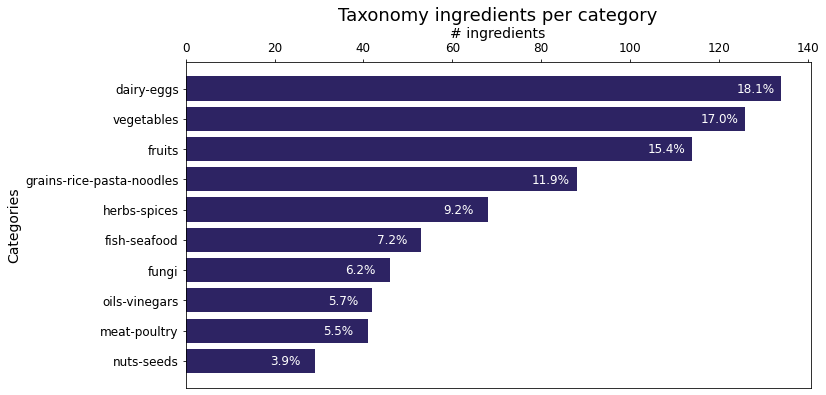

In [5]:
### Plot ingredient count

df_taxonomy_grouped = pd.DataFrame(df_taxonomy['category_name'].value_counts().head(10)).reset_index()
df_taxonomy_grouped.rename(columns = {'index': 'category', 'category_name': 'count'}, inplace = True)
df_taxonomy_grouped['dist'] = df_taxonomy_grouped['count'] / sum(df_taxonomy_grouped['count'])

TAXONOMY_COUNT = sum(df_taxonomy_grouped['count'])

# Plot figure
fig, ax = plt.subplots(1, 1, figsize = (FIG_WIDTH * 0.7, FIG_HEIGHT)) # Create figure and axes

ax.barh(df_taxonomy_grouped['category'],
        df_taxonomy_grouped['count'],
        color = '#2D2363')

# Format plot
plot_params = {'title': 'Taxonomy ingredients per category',
             'x_label': '# ingredients',
             'y_label': 'Categories'}

plot_formatting(ax, plot_params, has_legend = False, ignore_ticks = True)
ax.tick_params(axis = 'y', which = 'major', labelsize = PLOT_CONFIG['tick'])
ax.invert_yaxis()

# Format x axis
ax.tick_params(axis = 'x', which = 'major', labelsize = PLOT_CONFIG['tick'],
              bottom = False, top = True, labelbottom = False, labeltop = True)
ax.xaxis.set_label_position('top') 

# Add text
X_POS_DELTA = -0.12
Y_POS_DELTA = 10

for x, y in enumerate(df_taxonomy_grouped['dist']):
    ax.text(TAXONOMY_COUNT * y - Y_POS_DELTA,
            x - X_POS_DELTA,
            '{:.1%}'.format(y),
            color = '#ffffff',
            fontsize = PLOT_CONFIG['legend'])

plt.show()

In [6]:
### Random sample of table

df_taxonomy.sample(5, random_state = RANDOM_STATE)

,id,ingredient_name,category_id,category_name,taxonomy
409,411,lemons,108,fruits,kafoodle-pantry:fruits:fresh-fruits:citrus
689,691,ground-cloves,148,herbs-spices,kafoodle-pantry:herbs-spices:spices:cloves
5,6,jumbo-shrimps,101,fish-seafood,kafoodle-pantry:fish-seafood:crustaceans:shrimps
202,204,almond-milks,105,nuts-seeds,kafoodle-pantry:nuts-seeds:nut-milks
420,422,green-grapes,108,fruits,kafoodle-pantry:fruits:fresh-fruits:grapes


### A good sentence transformer

In [7]:
### Load ingredient taxonomy

STRING_CONNECTION = generate_string_connection()

df_matched_ingredients = sql_to_dataframe('kp_ingredients_matched', STRING_CONNECTION)

Query successfully executed.


In [8]:
### Save copy in excel to calibrate

df_matched_ingredients.sample(100, random_state = RANDOM_STATE).to_excel(PATH_EXCEL + 'calibration_sample.xlsx',
                                                                        index = False,
                                                                        sheet_name = 'original_sample')

In [9]:
### Import data to match models

df_model_selection = pd.read_excel(PATH_EXCEL + 'calibration_sample_matched.xlsx', sheet_name = 'matched_sample')

In [10]:
### Load models

sentence_model_768 = SentenceTransformer('paraphrase-mpnet-base-v2')
sentence_model_384 = SentenceTransformer('all-MiniLM-L6-v2')
sentence_model_384_2 = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sentence_model_512 = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [11]:
### Test models

MODELS = {'384': sentence_model_384,
          '384_2': sentence_model_384_2,
          '512': sentence_model_512,
          '768': sentence_model_768}

df_model_selection_scored = df_model_selection.copy()

TIME = {}

for I, MODEL in MODELS.items():

    T1 = time.time()
    
    SENT_1 = MODEL.encode(df_model_selection_scored['ingredient_name'])
    SENT_2 = MODEL.encode(df_model_selection_scored['taxonomy_name'])
    METRIC = [cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0] for x, y in zip(SENT_1, SENT_2)]
    
    df_model_selection_scored[I] = METRIC
    
    TIME[I] = time.time() - T1

In [12]:
### Random sample of matching results

df_model_selection_scored.sample(5, random_state = RANDOM_STATE)

,ingredient_name,taxonomy_name,384,384_2,512,768
88,Avocado Pears Hass 18,avocado,0.565832,0.616846,0.143329,0.748469
42,Rockport Pasteurised White Crab Meat 454g,crab,0.572630,0.696750,0.357841,0.585924
55,Prawn Marie Rose Sandwich Filling,prawns,0.473382,0.368149,0.146052,0.598059
15,Beetroot Baby,beet,0.635856,0.681043,0.525401,0.743135
0,C/r Battered Cod 140/170g 5/6oz,cod-fillets,0.434795,0.539797,0.262111,0.618901


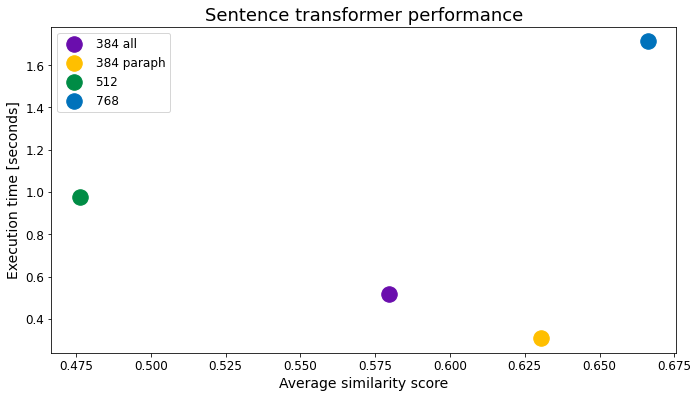

In [13]:
### Plot results

COLOURS = {'384': '#6a0dad',
          '384_2': '#ffbf00',
          '512': '#008C45',
          '768': '#0072bb'}

LABELS = {'384': '384 all',
          '384_2': '384 paraph',
          '512': '512',
          '768': '768'}

# Plot figure
fig, ax = plt.subplots(1, 1, figsize = (FIG_WIDTH * 0.7, FIG_HEIGHT)) # Create figure and axes

for I, COLOUR in COLOURS.items():
    
    AVG_SCORE = df_model_selection_scored[I].mean()
    
    ax.scatter(AVG_SCORE,
              TIME[I],
              color = COLOUR,
              label = LABELS[I],
              s = 240)

# Format plot
plot_params = {'title': 'Sentence transformer performance',
             'x_label': 'Average similarity score',
             'y_label': 'Execution time [seconds]'}

plot_formatting(ax, plot_params, has_legend = True)
    
plt.show()

In [14]:
### Compute df with distributions

df_model_selection_scored_grouped = df_model_selection_scored.copy()
df_model_selection_scored_grouped['idxmax'] = df_model_selection_scored_grouped[['384', '384_2', '512', '768']].idxmax(axis = 1)

df_model_selection_scored_grouped = pd.DataFrame(df_model_selection_scored_grouped['idxmax'].value_counts()).reset_index()
df_model_selection_scored_grouped.sort_values(by = 'index', inplace = True)
df_model_selection_scored_grouped['label'] = df_model_selection_scored_grouped['index'].map(LABELS)

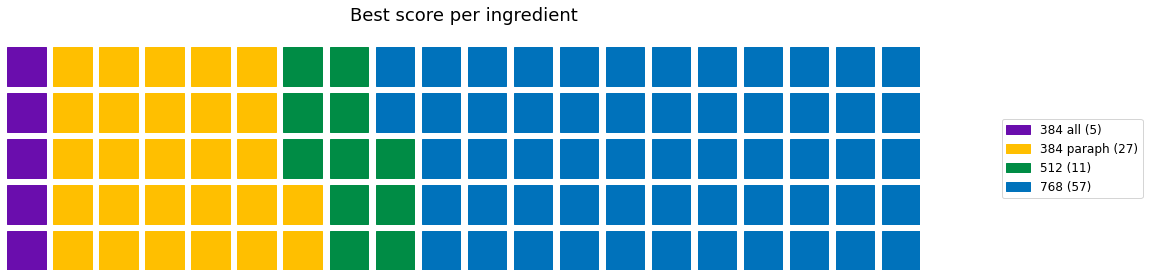

In [15]:
### Plot waffle results

fig = plt.figure(
    FigureClass = Waffle,
    values = df_model_selection_scored_grouped['idxmax'],
    labels = ['{0} ({1})'.format(n[0], n[1]) for n in df_model_selection_scored_grouped[['label', 'idxmax']].itertuples(index = False)],
    legend = {'loc': 'right',
        'bbox_to_anchor': (1.25, 0.5),
        'fontsize': PLOT_CONFIG['legend']},
        title = {'label': 'Best score per ingredient\n',
        'loc': 'center',
        'fontsize': PLOT_CONFIG['title']},
        rows = 5,
        colors = list(COLOURS.values()),
        figsize = (FIG_WIDTH, FIG_HEIGHT))

fig.show()

### Feature engineering of textual ingredients

In [16]:
### Import necesary files

df_raw_ingredients = sql_to_dataframe('kp_ingredients_base_pantry', STRING_CONNECTION)

df_sample_ingredients = df_raw_ingredients.sample(SAMPLE_SIZE, random_state = RANDOM_STATE)

Query successfully executed.


In [17]:
### Round 1: vectorise per category and compute scores

INIT_TIME = time.time()

list_categories = df_taxonomy['category_id'].unique()

dict_taxonomy_categorised = {}
dict_ingredients_categorised = {}
dict_matched_ingredients = {}

for CAT in list_categories:
    
    list_taxonomy_categorised = df_taxonomy[df_taxonomy['category_id'] == CAT]['ingredient_name'].tolist()
    list_ingredient_categorised = df_sample_ingredients[df_sample_ingredients['category_id'] == CAT]['ingredient_name'].tolist()
    
    if len(list_taxonomy_categorised) == 0:
        print(f'Did not find any ingredient for category {CAT} in taxonomy. Moving on.')
        continue
        
    elif len(list_ingredient_categorised) == 0:
        print(f'Did not find any ingredient for category {CAT} in ingredients. Moving on.')
        continue
        
    dict_taxonomy = vectorise_sentence(list_taxonomy_categorised)
    dict_ingredients = vectorise_sentence(list_ingredient_categorised)
        
    dict_taxonomy_categorised[CAT] = dict_taxonomy
    dict_ingredients_categorised[CAT] = dict_ingredients
    
    dict_matched_ingredients[CAT] = calculate_similarity(dict_taxonomy, dict_ingredients)
    
    print(f'Finalised with category {CAT}. Moving on.')

FINAL_TIME = time.time() - INIT_TIME
    
print(f'Finalised all ingredients. Total time: {FINAL_TIME:.2f} seconds')

Vectorisation finished. Total time: 0.62 seconds
Vectorisation finished. Total time: 5.15 seconds
Finalised with category 101. Moving on.
Vectorisation finished. Total time: 0.52 seconds
Vectorisation finished. Total time: 18.41 seconds
Finalised with category 102. Moving on.
Vectorisation finished. Total time: 0.86 seconds
Vectorisation finished. Total time: 12.13 seconds
Finalised with category 103. Moving on.
Vectorisation finished. Total time: 0.31 seconds
Vectorisation finished. Total time: 0.09 seconds
Finalised with category 105. Moving on.
Vectorisation finished. Total time: 0.89 seconds
Vectorisation finished. Total time: 8.42 seconds
Finalised with category 107. Moving on.
Vectorisation finished. Total time: 0.82 seconds
Vectorisation finished. Total time: 3.22 seconds
Finalised with category 108. Moving on.
Vectorisation finished. Total time: 0.67 seconds
Vectorisation finished. Total time: 1.93 seconds
Finalised with category 109. Moving on.
Vectorisation finished. Total ti

In [18]:
### Create dict to save results

dict_results = {'round': [],
               'description': [],
               'execution_time': [],
               'average_score': [],
               'ratio_over_80': []}

In [19]:
### Round 1: compute results

dict_categories = {key: [key] * len(content['ingredient']) for key, content in dict_matched_ingredients.items()}

df_category_results = pd.DataFrame(columns = ['category_id', 'ingredient', 'matched_ingredient', 'matched_score'])

for CAT in dict_categories.keys():
    
#     DF = pd.DataFrame({'category_id': dict_categories[CAT]} | dict_matched_ingredients[CAT])
    NEW_DICT = {'category_id': dict_categories[CAT]}
    NEW_DICT.update(dict_matched_ingredients[CAT])
    DF = pd.DataFrame(NEW_DICT)
    df_category_results = pd.concat([df_category_results, DF])
    
df_category_results.reset_index(drop = True, inplace = True)
    
AVG_SCORE = df_category_results['matched_score'].mean()
RATIO_OVER_80 = sum(df_category_results['matched_score'] >= 0.8) / len(df_category_results)
    
print(f'Time to compute: {FINAL_TIME:.2f} seconds')
print(f'Average matching score: {AVG_SCORE:.3f}')
print(f'Ratio over 0.8: {RATIO_OVER_80:.3f}')

# Append results
dict_results['round'].append(1)
dict_results['description'].append('Baseline model')
dict_results['execution_time'].append(FINAL_TIME)
dict_results['average_score'].append(AVG_SCORE)
dict_results['ratio_over_80'].append(RATIO_OVER_80)

Time to compute: 63.74 seconds
Average matching score: 0.630
Ratio over 0.8: 0.119


In [20]:
### Round 2: run all possible combinations

INIT_TIME = time.time()

list_taxonomy = df_taxonomy['ingredient_name'].tolist()
list_ingredient = df_sample_ingredients['ingredient_name'].tolist()

dict_taxonomy = vectorise_sentence(list_taxonomy)
dict_ingredients = vectorise_sentence(list_ingredient)

dict_similarity = calculate_similarity(dict_taxonomy, dict_ingredients)

df_all_results_baseline = pd.DataFrame(dict_similarity)
AVG_SCORE = df_all_results_baseline['matched_score'].mean()
RATIO_OVER_80 = sum(df_all_results_baseline['matched_score'] >= 0.8) / len(df_all_results_baseline)

FINAL_TIME = time.time() - INIT_TIME

print(f'Time to compute: {FINAL_TIME:.2f} seconds')
print(f'Average matching score: {AVG_SCORE:.3f}')
print(f'Ratio over 0.8: {RATIO_OVER_80:.3f}')

# Append results
dict_results['round'].append(2)
dict_results['description'].append('All combinations')
dict_results['execution_time'].append(FINAL_TIME)
dict_results['average_score'].append(AVG_SCORE)
dict_results['ratio_over_80'].append(RATIO_OVER_80)

Vectorisation finished. Total time: 5.03 seconds
Vectorisation finished. Total time: 59.08 seconds
Time to compute: 64.19 seconds
Average matching score: 0.662
Ratio over 0.8: 0.132


In [21]:
### Round 3: remove numbers

INIT_TIME = time.time()

list_taxonomy = df_taxonomy['ingredient_name'].tolist()
list_ingredient = df_sample_ingredients['ingredient_name'].tolist()

list_removed_numbers_ingredients = [re.sub(r'[0-9]+', '', i) for i in list_ingredient]

dict_taxonomy = vectorise_sentence(list_taxonomy)
dict_removed_numbers_ingredients = vectorise_sentence(list_removed_numbers_ingredients)

dict_similarity = calculate_similarity(dict_taxonomy, dict_removed_numbers_ingredients)

df_noNumbers_results = pd.DataFrame(dict_similarity)
AVG_SCORE = df_noNumbers_results['matched_score'].mean()
RATIO_OVER_80 = sum(df_noNumbers_results['matched_score'] >= 0.8) / len(df_noNumbers_results)

FINAL_TIME = time.time() - INIT_TIME

print(f'Time to compute: {FINAL_TIME:.2f} seconds')
print(f'Average matching score: {AVG_SCORE:.3f}')
print(f'Ratio over 0.8: {RATIO_OVER_80:.3f}')

# Append results
dict_results['round'].append(3)
dict_results['description'].append('Numbers removed')
dict_results['execution_time'].append(FINAL_TIME)
dict_results['average_score'].append(AVG_SCORE)
dict_results['ratio_over_80'].append(RATIO_OVER_80)

Vectorisation finished. Total time: 4.95 seconds
Vectorisation finished. Total time: 54.11 seconds
Time to compute: 59.17 seconds
Average matching score: 0.672
Ratio over 0.8: 0.153


In [22]:
### Round 4: remove numbers and signs

INIT_TIME = time.time()

list_taxonomy = df_taxonomy['ingredient_name'].tolist()
list_ingredient = df_sample_ingredients['ingredient_name'].tolist()

list_removed_numbers_ingredients = [re.sub(r'[^A-Za-z ]+', '', i) for i in list_ingredient]

dict_taxonomy = vectorise_sentence(list_taxonomy)
dict_removed_numbers_ingredients = vectorise_sentence(list_removed_numbers_ingredients)

dict_similarity = calculate_similarity(dict_taxonomy, dict_removed_numbers_ingredients)

df_noNumbersAndSigns_results = pd.DataFrame(dict_similarity)
AVG_SCORE = df_noNumbersAndSigns_results['matched_score'].mean()
RATIO_OVER_80 = sum(df_noNumbersAndSigns_results['matched_score'] >= 0.8) / len(df_noNumbersAndSigns_results)

FINAL_TIME = time.time() - INIT_TIME

print(f'Time to compute: {FINAL_TIME:.2f} seconds')
print(f'Average matching score: {AVG_SCORE:.3f}')
print(f'Ratio over 0.8: {RATIO_OVER_80:.3f}')

# Append results
dict_results['round'].append(4)
dict_results['description'].append('Remove all but characters and whitespace')
dict_results['execution_time'].append(FINAL_TIME)
dict_results['average_score'].append(AVG_SCORE)
dict_results['ratio_over_80'].append(RATIO_OVER_80)

Vectorisation finished. Total time: 6.24 seconds
Vectorisation finished. Total time: 47.98 seconds
Time to compute: 54.32 seconds
Average matching score: 0.671
Ratio over 0.8: 0.150


In [23]:
# Round 5. Execution without stopwords

INIT_TIME = time.time()

# Import stopwords
with open(os.path.join(PATH_JSON, 'stopwords_list.json'), 'r') as f:
    dict_stopwords = json.load(f)

# Create lists
list_taxonomy = df_taxonomy['ingredient_name'].tolist()
list_ingredient = df_sample_ingredients['ingredient_name'].tolist()

# Process ingredients list
list_removed_numbers_ingredients = [re.sub(r'[^A-Za-z ]+', ' ', i) for i in list_ingredient] # Remove all but letters and spaces
list_removed_numbers_ingredients = [re.sub(r' +', ' ', i) for i in list_removed_numbers_ingredients] # Remove double spaces
list_removed_numbers_ingredients = [i.lower() for i in list_removed_numbers_ingredients] # lower caps

# Remove stopwords
double_list_ingredients = [i.split(' ') for i in list_removed_numbers_ingredients]
double_list_ingredients_sliced = [[i for i in sublist if i not in dict_stopwords['stopwords']] for sublist in double_list_ingredients]

# Reconstruct cleaned list
list_ingredients_clean = [' '.join(i).strip() for i in double_list_ingredients_sliced]

# Encode lists
dict_taxonomy = vectorise_sentence(list_taxonomy)
dict_ingredients_clean = vectorise_sentence(list_ingredients_clean)

dict_similarity = calculate_similarity(dict_taxonomy, dict_ingredients_clean)

df_clean_results = pd.DataFrame(dict_similarity)
df_clean_results['original_ingredient'] = list_ingredient

AVG_SCORE = df_clean_results['matched_score'].mean()
RATIO_OVER_80 = sum(df_clean_results['matched_score'] >= 0.8) / len(df_clean_results)

FINAL_TIME = time.time() - INIT_TIME

print(f'Time to compute: {FINAL_TIME:.2f} seconds')
print(f'Average matching score: {AVG_SCORE:.3f}')
print(f'Ratio over 0.8: {RATIO_OVER_80:.3f}')

# Append results
dict_results['round'].append(5)
dict_results['description'].append('Remove unwanted words')
dict_results['execution_time'].append(FINAL_TIME)
dict_results['average_score'].append(AVG_SCORE)
dict_results['ratio_over_80'].append(RATIO_OVER_80)

Vectorisation finished. Total time: 5.31 seconds
Vectorisation finished. Total time: 36.08 seconds
Time to compute: 41.63 seconds
Average matching score: 0.719
Ratio over 0.8: 0.291


In [24]:
### Create dataframe with result metrics

df_results = pd.DataFrame(dict_results)
df_results

,round,description,execution_time,average_score,ratio_over_80
0,1,Baseline model,63.744228,0.630471,0.1186
1,2,All combinations,64.189755,0.662467,0.1322
2,3,Numbers removed,59.169573,0.672341,0.1534
3,4,Remove all but characters and whitespace,54.322443,0.670508,0.1496
4,5,Remove unwanted words,41.634555,0.718596,0.2910


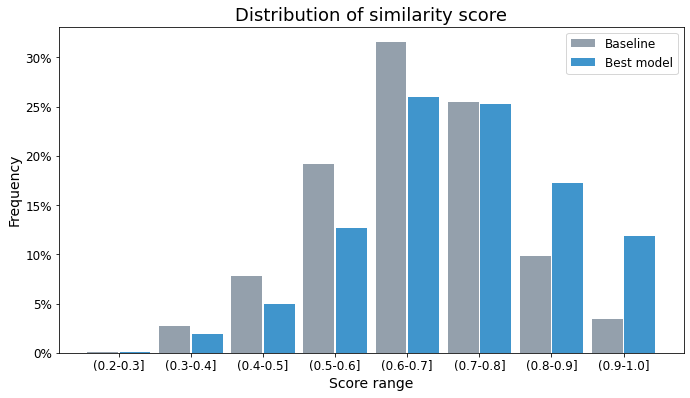

In [47]:
### Create histogram

df_histogram_baseline = df_all_results_baseline[['matched_score']]
df_histogram_best = df_clean_results[['matched_score']]
DF_ROWS = len(df_histogram_baseline)

# Round score
df_histogram_baseline['round_score'] = round(np.ceil(df_histogram_baseline['matched_score'] * 10) / 10, 1)
df_histogram_baseline.loc[df_histogram_baseline['round_score'] <= 0, 'round_score'] = 0
df_histogram_baseline.loc[df_histogram_baseline['round_score'] >= 1, 'round_score'] = 1

df_histogram_best['round_score'] = round(np.ceil(df_histogram_best['matched_score'] * 10) / 10, 1)
df_histogram_best.loc[df_histogram_best['round_score'] <= 0, 'round_score'] = 0
df_histogram_best.loc[df_histogram_best['round_score'] >= 1, 'round_score'] = 1

# Group results
df_histogram_grouped = df_histogram_baseline[['round_score']].groupby('round_score', as_index = False).size()
df_histogram_grouped['freq'] = df_histogram_grouped['size'] / DF_ROWS

df_histogram_grouped_best = df_histogram_best[['round_score']].groupby('round_score', as_index = False).size()
df_histogram_grouped_best['freq'] = df_histogram_grouped_best['size'] / DF_ROWS

# Generate axis
df_histogram_grouped['right_label'] = round(df_histogram_grouped['round_score'], 1).apply(str)
df_histogram_grouped['left_label'] = round(df_histogram_grouped['round_score'] - 0.1, 1).apply(str)
df_histogram_grouped['label'] = '(' + df_histogram_grouped['left_label'] + '-' + df_histogram_grouped['right_label'] + ']'

df_histogram_grouped_best['right_label'] = round(df_histogram_grouped_best['round_score'], 1).apply(str)
df_histogram_grouped_best['left_label'] = round(df_histogram_grouped_best['round_score'] - 0.1, 1).apply(str)
df_histogram_grouped_best['label'] = '(' + df_histogram_grouped_best['left_label'] + '-' + df_histogram_grouped_best['right_label'] + ']'

# Define plot consants
WIDTH = 0.45
ALPHA = 0.75
Y_MAX = round(np.ceil(df_histogram_grouped['freq'].max() / 0.05) * 0.05, 2)
X_POS_DELTA = 0.25
Y_POS_DELTA = -0.01

# Plot histogram
fig, ax = plt.subplots(1, 1, figsize = (FIG_WIDTH * 0.7, FIG_HEIGHT)) # Create figure and axes

ax.bar(df_histogram_grouped.index.values - WIDTH/2,
      df_histogram_grouped['freq'] * 100,
      width = WIDTH * 0.95,
      color = '#708090',
      alpha = ALPHA,
      label = 'Baseline')

ax.bar(df_histogram_grouped_best.index.values + WIDTH/2,
      df_histogram_grouped_best['freq'] * 100,
      width = WIDTH * 0.95,
      color = '#0072bb',
      alpha = ALPHA,
      label = 'Best model')

# Format x label
ax.set_xticks(df_histogram_grouped.index)
ax.set_xticklabels(df_histogram_grouped['label'])

# Format y label
yticks = mticker.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)

# Format plot
plot_params = {'title': 'Distribution of similarity score',
             'x_label': 'Score range',
             'y_label': 'Frequency'}

plot_formatting(ax, plot_params, has_legend = True)

plt.show()

In [35]:
df_clean_results.head()

,ingredient,matched_ingredient,matched_score,original_ingredient
0,cod,cod-fillets,0.750161,C/r Battered Cod 140/170g 5/6oz
1,toasted sesame oil,sesame-oils,0.836999,Prep Premium Toasted Sesame Oil
2,mixed,mixed-mushrooms,0.438526,Prep Mixed Scottish Soup Po D3
3,greek yoghurt yter,greek-yogurts,0.839107,Greek Style Yoghurt Yter Farm 2k
4,chilli red diced chicken breast fillet fresh,chicken-breasts,0.662336,D5 2.5kg Chilli Salsa Flavour Red Tractor Dice...


### Choosing a threshold for the score

In [50]:
### Retrieve table

df_ingredients_nutrition = sql_to_dataframe('kp_ingredients_nutrition', STRING_CONNECTION)
DF_ROWS = len(df_ingredients_nutrition)

df_ingredients_nutrition.head()

Query successfully executed.


,ingredient_id,original_ingredient_name,matched_ingredient,matched_score,ingredient_category_id,taxonomy_category_id,nutrition_id,has_nutrition_data,energy_quantity,energy_unit,...,NUTS_PECANS,NUTS_BRAZIL,NUTS_PISTACHIOS,NUTS_MACADAMIA,SESAME_SEEDS,SULPHUR_DIOXIDE,MOLLUSCS,CELERY,MUSTARD,LUPIN
0,640848,Young's Breaded White Fish Fishcakes,wrekin-white,0.576438,101,107,892464,1,239,kcal,...,0,0,0,0,0,0,0,0,1,0
1,640849,Msc Breaded White Fish Fillet 50-70g,cod-fillets,0.741485,101,101,892465,1,199,kcal,...,0,0,0,0,0,0,0,0,0,0
2,640850,Pier 7 Raw Scottish Salmon Portions Skinless 1...,canned-salmons,0.847515,101,101,892466,1,217,kcal,...,0,0,0,0,0,0,0,0,0,0
3,640912,GG Pickled cockles,pickled-peppers,0.759848,101,103,892528,1,None,None,...,0,0,0,0,0,0,1,0,0,0
4,640915,GG Mussels,mussels,1.000000,101,101,892531,1,None,None,...,0,0,0,0,0,0,1,0,0,0


In [51]:
### Build dataframe with varying score

INIT_INGREDIENTS = len(df_ingredients_nutrition['matched_ingredient'].unique())

# Initialise dict
dict_sensibility = {}

dict_sensibility['cutoff_score'] = np.linspace(0, 1, 101)
dict_sensibility['ingredients'] = []
dict_sensibility['preserved_rows'] = []
dict_sensibility['ingredients_retained'] = []
dict_sensibility['category_match'] = []
dict_sensibility['null_energy'] = []
dict_sensibility['mean_volatility'] = []

# Compute metrics
for threshold in dict_sensibility['cutoff_score']:

    # Slice dataframe
    df_sliced = df_ingredients_nutrition[df_ingredients_nutrition['matched_score'] >= threshold]

    # Count rows
    N_ROWS = len(df_sliced)

    # Different ingredients
    NUM_INGREDIENTS = len(df_sliced['matched_ingredient'].unique())

    # Category match
    MATCH = sum(df_sliced['ingredient_category_id'] == df_sliced['taxonomy_category_id'])

    # Null energy
    NULL_ENERGY = sum(df_sliced['energy_quantity'].isnull())

    # Volatility of ingredients - energy
    df_ingredients = df_sliced[df_sliced['energy_unit'] == 'kcal']
    df_ingredients['energy_quantity'] = pd.to_numeric(df_ingredients['energy_quantity'])

    df_ingredients = df_ingredients[['matched_ingredient', 'energy_quantity']].groupby('matched_ingredient').agg('std')
    df_ingredients['energy_quantity'].fillna(0, inplace = True)
    df_ingredients.rename(columns = {'energy_quantity': 'energy_std'}, inplace = True)

    MEAN_VOLATILITY = np.mean(df_ingredients['energy_std'])

    # Update list
    dict_sensibility['ingredients'].append(N_ROWS)
    dict_sensibility['preserved_rows'].append(N_ROWS / DF_ROWS)
    dict_sensibility['ingredients_retained'].append(NUM_INGREDIENTS / INIT_INGREDIENTS)
    dict_sensibility['category_match'].append(MATCH / N_ROWS)
    dict_sensibility['null_energy'].append(NULL_ENERGY / N_ROWS)
    dict_sensibility['mean_volatility'].append(MEAN_VOLATILITY)

# Compute dataframe
df_sensibility = pd.DataFrame(dict_sensibility)

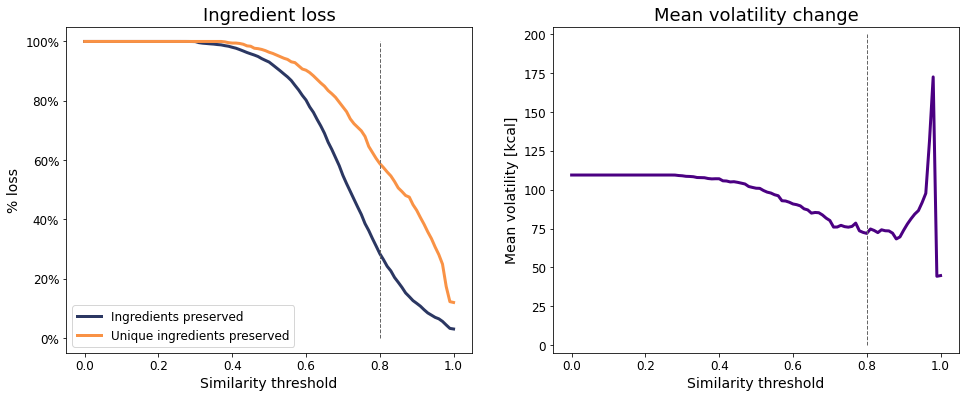

In [65]:
### Plot support plots

fig, axs = plt.subplots(1, 2, figsize = (FIG_WIDTH, FIG_HEIGHT))
X_LABEL = 'Similarity score cutoff'
LINEWIDTH = 3
VISIBILITY = True

# Plot retention
axs[0].plot(df_sensibility['cutoff_score'],
              df_sensibility['preserved_rows'] * 100,
              color = '#2b3762',
              label = 'Ingredients preserved',
              lw = LINEWIDTH)

axs[0].plot(df_sensibility['cutoff_score'],
              df_sensibility['ingredients_retained'] * 100,
              color = '#f99245',
              label = 'Unique ingredients preserved',
              lw = LINEWIDTH)

# Plot reference line at 0.8
axs[0].plot((0.8, 0.8),
              (0, 100),
              color = '#666666',
              lw = 1,
              linestyle = '--')

# Format plot
plot_params = {'title': 'Ingredient loss',
             'x_label': 'Similarity threshold',
             'y_label': '% loss'}

plot_formatting(axs[0], plot_params, has_legend = True)

axs[0].yaxis.set_major_formatter(yticks)

# Plot volatility
axs[1].plot(df_sensibility['cutoff_score'],
              df_sensibility['mean_volatility'],
              color = '#4b0082',
              lw = LINEWIDTH)

# Plot reference line at 0.8
axs[1].plot((0.8, 0.8),
              (0, 200),
              color = '#666666',
              lw = 1,
              linestyle = '--')

# Format volatility
plot_params = {'title': 'Mean volatility change',
             'x_label': 'Similarity threshold',
             'y_label': 'Mean volatility [kcal]'}

plot_formatting(axs[1], plot_params)
axs[1].set_ylim([-5, 205])

plt.show()

In [73]:
### Compute dataframe of carrots

df_carrots = df_ingredients_nutrition[df_ingredients_nutrition['matched_ingredient'] == 'carrots']
df_carrots['energy_quantity'] = pd.to_numeric(df_carrots['energy_quantity'], errors = 'coerce')
df_carrots.head()

,ingredient_id,original_ingredient_name,matched_ingredient,matched_score,ingredient_category_id,taxonomy_category_id,nutrition_id,has_nutrition_data,energy_quantity,energy_unit,...,NUTS_PECANS,NUTS_BRAZIL,NUTS_PISTACHIOS,NUTS_MACADAMIA,SESAME_SEEDS,SULPHUR_DIOXIDE,MOLLUSCS,CELERY,MUSTARD,LUPIN
101,641420,Carrot,carrots,0.913558,103,103,893036,1,NaN,None,...,0,0,0,0,0,0,0,0,0,0
127,641756,Sliced Carrots,carrots,0.862605,103,103,893372,1,35.0,kcal,...,0,0,0,0,0,0,0,0,0,0
128,641757,Baby Carrots,carrots,0.872419,103,103,893373,1,35.0,kcal,...,0,0,0,0,0,0,0,0,0,0
251,643087,Carrots,carrots,1.000000,103,103,894703,1,42.0,kcal,...,0,0,0,0,0,0,0,0,0,0
278,643472,Carrot 10kg Bag,carrots,0.913558,103,103,895088,1,41.0,kcal,...,0,0,0,0,0,0,0,0,0,0


In [74]:
### Compute plots for carrots

DF_ROWS_CARROTS = len(df_carrots)

# Initialise dict
dict_sensibility_carrots = {}

dict_sensibility_carrots['cutoff_score'] = np.linspace(0, 1, 101)
dict_sensibility_carrots['ingredients'] = []
dict_sensibility_carrots['preserved_rows'] = []
dict_sensibility_carrots['category_match'] = []
dict_sensibility_carrots['null_energy'] = []
dict_sensibility_carrots['mean_volatility'] = []

# Compute metrics
for threshold in dict_sensibility_carrots['cutoff_score']:

    # Slice dataframe
    df_sliced = df_carrots[df_carrots['matched_score'] >= threshold]

    # Count rows
    N_ROWS = len(df_sliced)

    # Category match
    MATCH = sum(df_sliced['ingredient_category_id'] == df_sliced['taxonomy_category_id'])

    # Null energy
    NULL_ENERGY = sum(df_sliced['energy_quantity'].isnull())

    # Volatility of ingredients - energy
    df_ingredients = df_sliced[df_sliced['energy_unit'] == 'kcal']
    df_ingredients['energy_quantity'] = pd.to_numeric(df_ingredients['energy_quantity'])

    df_ingredients = df_ingredients[['matched_ingredient', 'energy_quantity']].groupby('matched_ingredient').agg('std')
    df_ingredients['energy_quantity'].fillna(0, inplace = True)
    df_ingredients.rename(columns = {'energy_quantity': 'energy_std'}, inplace = True)

    MEAN_VOLATILITY = np.mean(df_ingredients['energy_std'])

    # Update list
    dict_sensibility_carrots['ingredients'].append(N_ROWS)
    dict_sensibility_carrots['preserved_rows'].append(N_ROWS / DF_ROWS_CARROTS)
    dict_sensibility_carrots['category_match'].append(MATCH / N_ROWS)
    dict_sensibility_carrots['null_energy'].append(NULL_ENERGY / N_ROWS)
    dict_sensibility_carrots['mean_volatility'].append(MEAN_VOLATILITY)

# Compute dataframe
df_sensibility_carrots = pd.DataFrame(dict_sensibility_carrots)

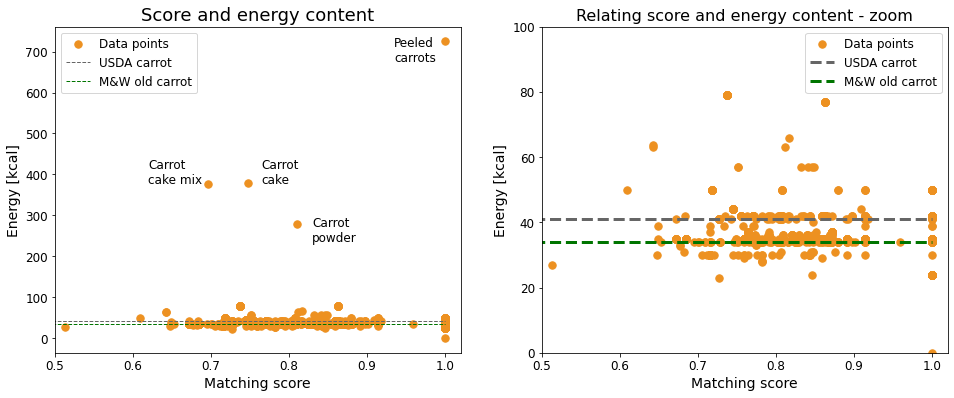

In [97]:
### Distribution of carrots

df_carrots_energy = df_carrots[df_carrots['energy_unit'] == 'kcal']
df_carrots_energy['energy_quantity'] = pd.to_numeric(df_carrots_energy['energy_quantity'])

# References
USDA_CARROT = 41
MW_CARROT = 34

COLOURS_CARROT = {'points': '#ed9121',
                 'usda': '#666666',
                 'mw': '#007500'}

# Define plots
fig, axs = plt.subplots(1, 2, figsize = (FIG_WIDTH, FIG_HEIGHT))

# Scatter plot - general
axs[0].scatter(df_carrots_energy['matched_score'],
               df_carrots_energy['energy_quantity'],
               color = COLOURS_CARROT['points'],
               s = 55,
               label = 'Data points')

axs[0].plot([0, 1],
            [USDA_CARROT] * 2,
            color = COLOURS_CARROT['usda'],
            lw = 1,
            linestyle = '--',
            label = 'USDA carrot')

axs[0].plot([0, 1],
            [MW_CARROT] * 2,
            color = COLOURS_CARROT['mw'],
            lw = 1,
            linestyle = '--',
            label = 'M&W old carrot')

# Format plot
plot_params = {'title': 'Score and energy content',
             'x_label': 'Matching score',
             'y_label': 'Energy [kcal]'}

plot_formatting(axs[0], plot_params, has_legend = True)
axs[0].set_xlim([0.5, 1.02])

# Set labels
TEXT_LABELS = [[0.83, 235, 'Carrot\npowder'],
               [0.765, 379, 'Carrot\ncake'],
               [0.62, 377, 'Carrot\ncake mix'],
               [0.935, 675, 'Peeled\ncarrots']]

for DATA in TEXT_LABELS:
    axs[0].text(DATA[0],
                DATA[1],
                DATA[2],
                color = '#000000',
                fontsize = PLOT_CONFIG['tick'])

# Scatter plot - zoom
axs[1].scatter(df_carrots_energy['matched_score'],
               df_carrots_energy['energy_quantity'],
               color = COLOURS_CARROT['points'],
               s = 55,
               label = 'Data points')

axs[1].plot([0, 1],
            [USDA_CARROT] * 2,
            color = COLOURS_CARROT['usda'],
            lw = 3,
            linestyle = '--',
            label = 'USDA carrot')

axs[1].plot([0, 1],
            [MW_CARROT] * 2,
            color = COLOURS_CARROT['mw'],
            lw = 3,
            linestyle = '--',
            label = 'M&W old carrot')

# Format plot - zoom
axs[1].set_title('Relating score and energy content - zoom', fontsize = PLOT_CONFIG['subtitle'])
axs[1].set_xlabel('Matching score', fontsize = PLOT_CONFIG['label'])
axs[1].set_ylabel('Energy [kcal]', fontsize = PLOT_CONFIG['label'])

axs[1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_CONFIG['tick'])
axs[1].legend(loc = 'best', fontsize = PLOT_CONFIG['legend'])
axs[1].set_xlim([0.5, 1.02])
axs[1].set_ylim([0, 100])

plt.show()

In [78]:
### Show outliers
df_carrots[df_carrots['energy_quantity'] > 200][['ingredient_id', 'original_ingredient_name', 'matched_score', 'energy_quantity']]

,ingredient_id,original_ingredient_name,matched_score,energy_quantity
5798,685192,Carrot Powder,0.810247,279.0
52991,1112891,Brakes Carrot Cake,0.747906,379.0
53941,1125114,Carrot Cake Mix Pre-order 12.5k,0.696207,377.0
65811,1228602,"Prep - Peeled, Washed Carrots",1.000000,725.0


In [99]:
df_carrots[df_carrots['energy_unit'] == 'kcal'].shape

(867, 50)

### Building the Pantry with statistics

In [101]:
1/39

0.02564102564102564